## RandomForest Baseline

__Папка с данными на gdrive__

https://drive.google.com/drive/folders/1FeUwrVfxp09xAifiMngwtfrRZ8nhtj8T?usp=sharing



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import shap
from matplotlib import pyplot as plt
from matplotlib import colors
from os import listdir
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from snippets import *

%matplotlib inline

In [2]:
DATA_PATH = "../../data"

GPS_PATH = f"{DATA_PATH}/gps_data_cycled_dist_angle.csv"
ACCEL_PATH = f"{DATA_PATH}/accel_data_cycled_dist_angle.csv"

listdir(DATA_PATH)

['data_good_right_dates',
 'drivers_stats.csv',
 'subm_accel_gps_proba.csv',
 'gps_data.csv',
 'unlabeled',
 'gps_data_raw.csv',
 'matched_routs.csv',
 'matched_routs_fixed.csv',
 'matched_data_fixed.csv',
 'good_data',
 'matched_data.csv',
 'gps_data_cycled_dist_angle.csv',
 'accel_data_cycled_dist_angle.csv',
 'accel_data_dist_angle.csv',
 'points_stats.csv',
 'proba_rf.csv',
 'subm_accel_tm.csv',
 'gps_data_fixed.csv',
 'gps_data_dist_angle.csv',
 'submission_rf.csv',
 'subm_accel_tm_proba.csv',
 'accel_data.csv',
 'accel_data_raw.csv',
 'drivers_with_gps_and_sl_problems',
 'accel_data_outlier.csv',
 'records',
 'track_20211214_211500.csv',
 'gps_stats.csv',
 'submission_catboost.csv',
 'subm_accel_gps.csv',
 'rides_of_drivers.csv',
 'accel_stats.csv',
 'gps_data_outlier.csv',
 'accel_data_fixed.csv',
 'proba_catboost.csv']

## gps_data_cycled_dist_angle data

In [3]:
df_gps = pd.read_csv(f"{DATA_PATH}/gps_data_cycled_dist_angle.csv", parse_dates=[0, 3]) \
    .sort_values(by=["driver_hash", "gps_time"]) \
    .reset_index(drop=True)
describe(df_gps)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],5050292,2020-07-31 17:37:31.378774272,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
lat,float64,5.05029e+06,55.743,42.98,55.6674,55.7496,55.8242,82.4343,0.171211
lon,float64,5.05029e+06,37.6021,26.1013,37.5009,37.5848,37.7032,135.46,0.401377
gps_time,datetime64[ns],5050292,2020-07-31 17:37:28.866647296,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
driver_hash,int64,5.05029e+06,3.03558e+17,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18,5.27957e+18
fraud,int64,5.05029e+06,-0.767609,-1,-1,-1,-1,1,0.470076
gps_delta,float64,5.05029e+06,6.85303,0.026,2,3,3,3600,84.5516
gps_cycled,float64,5.05029e+06,-6443.33,-11306.6,-8714.78,-6594.2,-4473.63,3.14159,2821.24
gps_distance,float64,5.05029e+06,19.6015,0,0.1,5.2,24.8,10000,180.181
gps_speed,float64,5.05029e+06,5.56799,0,0,2,9.7,100,7.80193


(5050292, 15)

In [4]:
df_accel = pd.read_csv(f"{DATA_PATH}/accel_data_cycled_dist_angle.csv", parse_dates=[0]) \
    .sort_values(by=["driver_hash", "time"]) \
    .reset_index(drop=True)
describe(df_accel)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],2172989,2020-11-22 12:54:59.277890560,2015-02-28 05:46:42.832594,2020-12-18 06:53:34.205120,2021-03-18 16:54:00.549220096,2021-06-12 11:02:18.664983040,2021-08-29 00:03:16.287344,NaN
x,float64,2.17299e+06,0.368934,-71.1054,-0.371101,0.184359,0.785298,65.1529,2.36914
y,float64,2.17299e+06,7.6569,-74.7916,7.63271,8.85376,9.50019,55.2294,3.4034
z,float64,2.17299e+06,3.83295,-65.5062,2.01402,3.69992,5.35365,76.4756,2.73072
lat,float64,2.17299e+06,55.7482,55.3163,55.6768,55.7512,55.8214,82.4343,0.16893
lon,float64,2.17299e+06,37.601,36.3143,37.5016,37.5863,37.686,108.856,0.376061
driver_hash,int64,2.17299e+06,-1.12657e+17,-9.21858e+18,-4.47912e+18,-4.14168e+17,4.43147e+18,9.20647e+18,5.3536e+18
fraud,int64,2.17299e+06,-0.796897,-1,-1,-1,-1,1,0.509161
acc_delta,float64,2.17299e+06,370.615,0.009,0.547,0.772,1.919,3600,1091.83
acc_cycled,float64,2.17299e+06,-6472.32,-11306.6,-8714.78,-6594.2,-4473.63,3.14159,2717.17


(2172989, 17)

## Разбивка на поездки

In [5]:
ROUTE_SPLIT_COLUMN = "gps_delta"
ROUTE_SPLIT_INTERVAL = 300

# разбиваю на поездки, если между точками разница больше ROUTE_SPLIT_INTERVAL секунд
route_diff = pd.to_timedelta(df_gps[ROUTE_SPLIT_COLUMN], unit="seconds") \
    .dt.total_seconds()

df_gps["gps_start"] = 0
df_gps.loc[route_diff > ROUTE_SPLIT_INTERVAL, "gps_start"] = 1

df_gps["gps_route"] = df_gps["gps_start"].cumsum().astype(int)

df_gps[["gps_time", "gps_delta", "gps_start", "gps_route"]]

,gps_time,gps_delta,gps_start,gps_route
0,2020-11-10 03:08:12,3600.0,1,1
1,2020-11-10 03:42:48,2076.0,1,2
2,2020-11-10 06:38:30,3600.0,1,3
3,2020-11-10 06:38:31,1.0,0,3
4,2020-11-10 06:54:36,965.0,1,4
...,...,...,...,...
5050287,2020-11-25 22:45:39,672.0,1,17335
5050288,2020-11-25 22:57:52,733.0,1,17336
5050289,2020-11-25 23:10:27,755.0,1,17337
5050290,2020-11-26 00:04:35,3248.0,1,17338


In [6]:
ROUTE_SPLIT_COLUMN = "acc_delta"
ROUTE_SPLIT_INTERVAL = 300

# разбиваю на поездки, если между точками разница больше ROUTE_SPLIT_INTERVAL секунд
route_diff = pd.to_timedelta(df_accel[ROUTE_SPLIT_COLUMN], unit="seconds") \
    .dt.total_seconds()

df_accel["acc_start"] = 0
df_accel.loc[route_diff > ROUTE_SPLIT_INTERVAL, "acc_start"] = 1

df_accel["acc_route"] = df_accel["acc_start"].cumsum().astype(int)

df_accel[["time", "acc_delta", "acc_start", "acc_route"]]

,time,acc_delta,acc_start,acc_route
0,2020-11-10 07:20:07.221246,3600.000,1,1
1,2020-11-10 07:20:07.224923,3.677,0,1
2,2020-11-10 07:20:07.225437,0.514,0,1
3,2020-11-10 07:20:07.226747,1.310,0,1
4,2020-11-10 07:20:07.228766,2.019,0,1
...,...,...,...,...
2172984,2020-11-26 18:21:43.961728,0.788,0,223327
2172985,2020-11-26 18:21:43.962476,0.748,0,223327
2172986,2020-11-26 18:21:43.967393,4.917,0,223327
2172987,2020-11-26 18:21:43.998950,31.557,0,223327


## Классификация точек

## Классификатор1

In [7]:
columns = ['lat', 'lon', 'gps_delta', 'gps_cycled', 
           'gps_distance', 'gps_speed', 'gps_accel', 'gps_angle',
           'gps_rspeed', 'gps_outlier', 'gps_staying']

X = df_gps.loc[df_gps["fraud"] >= 0, columns].copy()
y = df_gps.loc[df_gps["fraud"] >= 0, "fraud"].copy()

display(f"Features/Target: {(X.shape, y.shape)}")

X_train, X_test, y_train, y_test = train_test_split(X, y)
display(f"Train/Test: {(X_train.shape, y_train.shape, X_test.shape, y_test.shape)}")

clf_gps = RandomForestClassifier(n_jobs=-1)
clf_gps.fit(X_train, y_train)
proba = clf_gps.predict_proba(X_test)

imps = pd.Series(clf_gps.feature_importances_, X_train.columns).sort_values(ascending=False)
display(imps.rename("Importances").to_frame().T)

'Features/Target: ((1066109, 11), (1066109,))'

'Train/Test: ((799581, 11), (799581,), (266528, 11), (266528,))'

,lat,lon,gps_cycled,gps_delta,gps_speed,gps_distance,gps_accel,gps_angle,gps_rspeed,gps_staying,gps_outlier
Importances,0.320782,0.280702,0.180437,0.049143,0.040291,0.039972,0.031283,0.027446,0.02648,0.002988,0.000476


Train    80960.0
Test     26575.0
Pred     25244.0
dtype: float64

accuracy_score    0.991900
f1_score          0.958336
dtype: float64

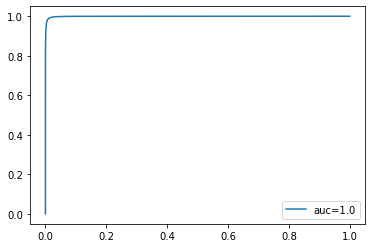

In [8]:
y_pred = pd.Series(proba.argmax(axis=1), index=X_test.index, name="Pred")
display(pd.concat((y_train.rename("Train"), y_test.rename("Test"), y_pred), axis=1).sum())

display(pd.Series((accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)),
                  index = ("accuracy_score", "f1_score")))

auc = roc_auc_score(y_test, proba[::,1])
fpr, tpr, _ = roc_curve(y_test,  proba[::,1])
plt.plot(fpr,tpr,label=f"auc={auc:.2}")
plt.legend(loc=4)
plt.show()

## Predictions

In [9]:
df_gps["gps_pred"] = clf_gps.predict(df_gps[columns])
df_gps["gps_pred"].value_counts()

0    4847321
1     202971
Name: gps_pred, dtype: int64

## Классификатор2

In [10]:
columns = ['x', 'y', 'z', 'lat', 'lon', 'acc_delta', 'acc_cycled',
           'acc_distance', 'acc_speed', 'acc_accel',
           'acc_angle', 'acc_rspeed', 'acc_outlier', 'acc_staying']

X = df_accel.loc[df_accel["fraud"] >= 0, columns].copy()
y = df_accel.loc[df_accel["fraud"] >= 0, "fraud"].copy()

display(f"Features/Target: {(X.shape, y.shape)}")

X_train, X_test, y_train, y_test = train_test_split(X, y)
display(f"Train/Test: {(X_train.shape, y_train.shape, X_test.shape, y_test.shape)}")

clf_acc = RandomForestClassifier(n_jobs=-1)
clf_acc.fit(X_train, y_train)
proba = clf_acc.predict_proba(X_test)

imps = pd.Series(clf_acc.feature_importances_, X_train.columns).sort_values(ascending=False)
display(imps.rename("Importances").to_frame().T)

'Features/Target: ((335525, 14), (335525,))'

'Train/Test: ((251643, 14), (251643,), (83882, 14), (83882,))'

,y,acc_delta,z,acc_distance,lat,acc_cycled,lon,x,acc_speed,acc_angle,acc_rspeed,acc_accel,acc_outlier,acc_staying
Importances,0.190981,0.134848,0.117742,0.109716,0.102523,0.098583,0.083311,0.078391,0.025273,0.019014,0.016451,0.015549,0.00426,0.003361


Train    79470.0
Test     26346.0
Pred     25419.0
dtype: float64

accuracy_score    0.973284
f1_score          0.956708
dtype: float64

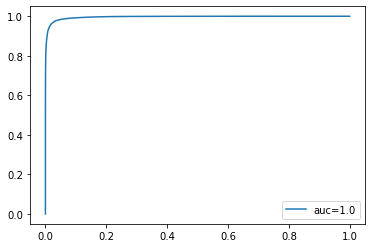

In [11]:
y_pred = pd.Series(proba.argmax(axis=1), index=X_test.index, name="Pred")
display(pd.concat((y_train.rename("Train"), y_test.rename("Test"), y_pred), axis=1).sum())

display(pd.Series((accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)),
                  index = ("accuracy_score", "f1_score")))

auc = roc_auc_score(y_test, proba[::,1])
fpr, tpr, _ = roc_curve(y_test,  proba[::,1])
plt.plot(fpr,tpr,label=f"auc={auc:.2}")
plt.legend(loc=4)
plt.show()

## Predictions

In [12]:
df_accel["acc_pred"] = clf_acc.predict(df_accel[columns])
df_accel["acc_pred"].value_counts()

0    1907344
1     265645
Name: acc_pred, dtype: int64

In [16]:
df_gps_pred = df_gps \
    .groupby(by=["fraud", "driver_hash"]) \
    .agg({"gps_pred": "sum", "fraud": "count"}) \
    .rename(columns={"fraud": "gps_points"}) \
    .sort_index()

df_accel_pred = df_accel \
    .groupby(by=["fraud", "driver_hash"]) \
    .agg({"acc_pred": "sum", "fraud": "count"}) \
    .rename(columns={"fraud": "acc_points"}) \
    .sort_index()

df_pred = df_gps_pred.merge(df_accel_pred, left_index=True, right_index=True)
df_pred.tail(50)

gps_pred  gps_points  acc_pred  acc_points
fraud driver_hash                                                     
-1     8441926883992743797       870       38528       501        9984
       8472641716551984138         6        8475        11        3013
       8484618983568667576        51       24589       556        9975
       8495411695898023080         5       22783       632        9984
       8708539809027958552       442       31907       198        9997
       8799657288824140068       276       20439        91        9558
       8894636921649230831         6       13871        72        7193
       8921990331059051231        10       23350         0        1532
       8979134000488028450       411       24378       217        9998
       8979322487342770688         4        1060      1143        3404
       9028001926696043346         0       17144        41        9998
       9142516420276355425       263        7481       596        4656
       9206466041403273735        32       19370        49        9989
 0    -8855449059095575743        28       44773        13        9967
      -8285444573847573076         6       25396        23        9994
      -4472006672024242679         5       36834        46        9915
      -4294745953159109974       105       40827        21        9989
      -4080393840523659459        11       41959        36        9990
      -3754613297758316782        13       46659         7        9988
      -2326108064915089301        13       22128        11        9976
      -917569374742463282          1       85301         1        9998
       50909632375203636           8       53188        12        9995
       102237250308562244         21       55713         0        9996
       254619638422759589          2       50866        21        9994
       269342988796658819         34       44981        27        9985
       631642712709916337          9       31776        23        9991
       2339565149906962126         6       34398        71        9989
       4633179079544742811         6       57838         3        9995
       4792989220905314639         8       25243        24        9996
       4805235792201203747         8       24202       210        9998
       4957397998143787649        14       30327        18        9992
       5900186570978300677        42       34018        16        9997
       5960642249321857991        20       42616        42        9988
       7363918686470073741        34       50682        22        9994
       7934040023444826650         3       46228         6        9986
       8893554023910460211        17       32621         4        9996
 1    -8915411586673655243        47          55      2664        2690
      -8729475955540025841      3082        3087      2469        2521
      -7745607963253656189     15909       15994      9418        9471
      -7078426713190014901      1716        1799      5456        5497
      -6715898809375179473     14477       14887      9705        9995
      -4687681644253937266      1985        1995      8152        8300
      -4385647888228392778      6061        6131      9947        9996
      -3962756297262839169     10834       11129      9874        9954
      -2988946964244641879      7470        7755      4510        4837
      -2132251359044308970      7633        7749      9903        9997
       1293535473153840726        15          17      9616        9675
       2025312357143911724     16643       16948      9700        9997
       2765355583032989810     19893       19965      9596        9597
       8569741546477592565        23          24      3221        3289

## Driver fraud rank

In [17]:
df_pred["gps_proba"] = df_pred["gps_pred"] / df_pred["gps_points"]
df_pred["acc_proba"] = df_pred["acc_pred"] / df_pred["acc_points"]
df_pred["fraud_gps"] = df_pred["gps_proba"].round(0).astype(int)
df_pred["fraud_acc"] = df_pred["acc_proba"].round(0).astype(int)
df_pred = df_pred.reset_index()
df_pred

,fraud,driver_hash,gps_pred,gps_points,acc_pred,acc_points,gps_proba,acc_proba,fraud_gps,fraud_acc
0,-1,-9218579406240981296,724,17592,495,9992,0.041155,0.049540,0,0
1,-1,-9148378939849570226,28,2430,34,889,0.011523,0.038245,0,0
2,-1,-9090289600630456229,872,4458,865,912,0.195603,0.948465,0,1
3,-1,-9073383204587901813,153,12885,55,9982,0.011874,0.005510,0,0
4,-1,-9067392653059450527,3289,14939,1191,9998,0.220162,0.119124,0,0
...,...,...,...,...,...,...,...,...,...,...
309,1,-2132251359044308970,7633,7749,9903,9997,0.985030,0.990597,1,1
310,1,1293535473153840726,15,17,9616,9675,0.882353,0.993902,1,1
311,1,2025312357143911724,16643,16948,9700,9997,0.982004,0.970291,1,1
312,1,2765355583032989810,19893,19965,9596,9597,0.996394,0.999896,1,1


## Earlier submisstion

In [19]:
df_rf = pd.read_csv(f"{DATA_PATH}/submission_rf.csv")
df_rf.columns = ["driver_hash", "fraud_rf"]

df_cb = pd.read_csv(f"{DATA_PATH}/submission_catboost.csv")
df_cb.columns = ["driver_hash", "fraud_cb"]

df_submission = df_rf.merge(df_cb, on="driver_hash")
df_submission = df_pred.merge(df_submission, on="driver_hash")

df_submission[["fraud_gps", "fraud_acc", "fraud_rf", "fraud_cb"]].value_counts().sort_index()

fraud_gps  fraud_acc  fraud_rf  fraud_cb
0          0          0         0            94
                                1            16
                      1         0             2
                                1           159
           1          0         0             1
                      1         1             5
dtype: int64

## Clustering

In [27]:
columns = ['lat', 'lon', 'gps_delta', 'gps_cycled', 
           #'gps_distance', 'gps_speed', 'gps_accel', 
           'gps_angle', 'gps_rspeed',
           'gps_outlier', 'gps_staying'
          ]

df_clust = df_gps[["fraud", "driver_hash"]].copy()


for i in range(2, 12):
    np.random.seed(100)
    
    clust = KMeans(n_clusters=i)
    clust.fit(df_gps[columns])
    
    labels = pd.Series(clust.labels_, df_gps.index, name=f"clusters{i}")
    
    l = labels.value_counts().rename("Points")
    l0 = labels[df_gps["fraud"] == 0].value_counts().rename("Good")
    l1 = labels[df_gps["fraud"] == 1].value_counts().rename("Fraud")
    display(pd.concat((l, l0, l1), axis=1).T)
    
    df_clust = pd.concat((df_clust, labels.to_frame()), axis=1)


,0,1
Points,2685947,2364345
Good,493844,464730
Fraud,78702,28833


,0,1,2
Points,2218324,2045209,786759
Good,358530,392406,207638
Fraud,38580,57865,11090


,0,1,2,3
Points,1531742,1598903,1419271,500376
Good,301629,278773,235039,143133
Fraud,34568,11363,52012,9592


,0,1,2,3,4
Points,460551,1233737,1194755,1219203,942046
Good,130681,216525,189049,225643,196676
Fraud,9571,44732,29212,5686,18334


,0,1,2,3,4,5
Points,425986,894972,1150677,808341,787682,982634
Good,119074,142356,185204,169962,160452,181526
Fraud,9213,32973,16376,14238,3244,31491


,0,1,2,3,4,5,6
Points,425986,763170,630618,808341,795763,858818,767596
Good,119074,127965,134828,169962,124715,156948,125082
Fraud,9213,29580,2713,14238,21460,25777,4554


,0,1,2,3,4,5,6,7
Points,925269,817593,335780,771655,555955,699210,273169,671661
Good,160442,140771,85679,122977,118139,110513,86557,133496
Fraud,4634,32132,6793,24202,7553,11025,3016,18180


,0,1,2,3,4,5,6,7,8
Points,259183,669272,671661,556228,639768,555955,241193,689436,767596
Good,62502,105236,133496,110769,101847,118139,80631,120872,125082
Fraud,5397,16918,18180,2334,21973,7553,4195,26431,4554


,0,1,2,3,4,5,6,7,8,9
Points,556228,563359,555955,553674,512858,300602,671661,623150,199774,513031
Good,110769,99853,118139,86867,82417,74673,133496,102422,68460,81478
Fraud,2334,19996,7553,10211,20975,6078,18180,3331,3514,15363


,0,1,2,3,4,5,6,7,8,9,10
Points,528895,500570,326208,589696,259183,747459,511611,441476,430359,513467,201368
Good,83817,104669,76957,104953,62502,125040,81948,92007,67725,90777,68179
Fraud,15334,13608,1519,16234,5397,3353,16272,4726,3621,23297,4174


In [28]:
df_clust.groupby(["fraud", "driver_hash"], sort=True).agg(set).tail(50)

clusters2  clusters3     clusters4  \
fraud driver_hash                                               
-1     8441926883992743797    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       8472641716551984138    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       8484618983568667576    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       8495411695898023080    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       8708539809027958552    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       8799657288824140068    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       8894636921649230831    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       8921990331059051231    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       8979134000488028450    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       8979322487342770688    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       9028001926696043346    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       9142516420276355425    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       9206466041403273735    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
 0    -8855449059095575743    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
      -8285444573847573076    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
      -4472006672024242679    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
      -4294745953159109974    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
      -4080393840523659459    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
      -3754613297758316782    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
      -2326108064915089301    {0, 1}     {0, 1}     {0, 1, 2}   
      -917569374742463282     {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       50909632375203636      {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       102237250308562244     {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       254619638422759589     {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       269342988796658819     {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       631642712709916337     {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       2339565149906962126    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       4633179079544742811    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       4792989220905314639    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       4805235792201203747    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       4957397998143787649    {0, 1}  {0, 1, 2}     {0, 1, 3}   
       5900186570978300677    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       5960642249321857991    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       7363918686470073741    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       7934040023444826650    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       8893554023910460211    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
 1    -8915411586673655243    {0, 1}     {1, 2}        {0, 3}   
      -8729475955540025841    {0, 1}     {0, 1}     {0, 1, 2}   
      -7745607963253656189    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
      -7078426713190014901    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
      -6715898809375179473    {0, 1}  {0, 1, 2}     {0, 2, 3}   
      -4687681644253937266    {0, 1}     {0, 2}     {1, 2, 3}   
      -4385647888228392778    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
      -3962756297262839169    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
      -2988946964244641879    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
      -2132251359044308970    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       1293535473153840726    {0, 1}     {0, 2}        {1, 2}   
       2025312357143911724    {0, 1}  {0, 1, 2}  {0, 1, 2, 3}   
       2765355583032989810    {0, 1}     {0, 1}     {0, 1, 2}   
       8569741546477592565       {1}     {0, 2}     {1, 2, 3}   

                                  clusters5           clusters6  \
fraud driver_hash                                                 
-1     8441926883992743797  {0, 1, 2, 3, 4}  {0, 1, 2, 3, 4, 5}   
       8472641716551984138  {0, 1, 2, 3, 4}  {0, 1, 2, 3, 4, 5}   
       8484618983568667576     {1, 2, 3, 4}     {1, 2, 3, 4, 5}   
       8495411695898023080  {0, 1, 2, 3, 4}  {0, 1, 2, 3, 4, 5}   
       8708539809027958552  {0, 1, 2, 3, 4}  {0, 1, 2, 3, 4, 5}   
       8799657288824140068  {0, 1, 2, 3, 4}  {0, 1, 2, 3, 4, 5}   
       8894636921649230831  {0, 1, 2, 3, 4}  {0, 1, 2, 3, 4, 5}   
       8921990331059051231  {0, 1, 2, 3, 4}

In [29]:
columns = ['x', 'y', 'z', 'lat', 'lon', 'acc_delta', 'acc_cycled',
           'acc_distance', 'acc_speed', 'acc_accel',
           'acc_angle', 'acc_rspeed', 'acc_outlier', 'acc_staying']

df_clust = df_accel[["fraud", "driver_hash"]].copy()


for i in range(2, 12):
    np.random.seed(100)
    
    clust = KMeans(n_clusters=i)
    clust.fit(df_accel[columns])
    
    labels = pd.Series(clust.labels_, df_accel.index, name=f"clusters{i}")
    
    l = labels.value_counts().rename("Points")
    l0 = labels[df_accel["fraud"] == 0].value_counts().rename("Good")
    l1 = labels[df_accel["fraud"] == 1].value_counts().rename("Fraud")
    display(pd.concat((l, l0, l1), axis=1).T)
    
    df_clust = pd.concat((df_clust, labels.to_frame()), axis=1)


,1,0
Points,1105486,1067503
Good,116535,113174
Fraud,76654,29162


,0,1,2
Points,765496,657332,750161
Good,69522,76205,83982
Fraud,51262,9842,44712


,0,1,2,3
Points,865377,886713,196631,224268
Good,68014,85869,36916,38910
Fraud,30769,62983,6188,5876


,0,1,2,3,4
Points,582055,200132,686567,524610,179625
Good,48995,35568,54408,57332,33406
Fraud,48824,5876,15613,29577,5926


,0,1,2,3,4,5
Points,638770,563302,571344,187733,109848,101992
Good,50444,57737,48279,31286,21575,20388
Fraud,12165,32897,48688,5797,4440,1829


,0,1,2,3,4,5,6
Points,109848,440391,158941,444342,446332,101972,471163
Good,21576,37517,24778,39824,48350,20383,37281
Fraud,4440,38053,5798,3754,24928,1828,27015


,0,1,2,3,4,5,6,7
Points,367961,326483,158941,101972,109846,292135,371309,444342
Good,29235,30699,24778,20383,21576,32480,30734,39824
Fraud,18115,24459,5798,1828,4440,12226,35196,3754


,0,1,2,3,4,5,6,7,8
Points,388793,377809,147851,76623,372868,71957,370620,292131,74337
Good,30130,35236,22225,14111,34587,15293,30539,32479,15109
Fraud,16603,29605,5582,3312,1711,613,33605,12226,2559


,0,1,2,3,4,5,6,7,8,9
Points,444341,377808,74315,147848,370620,21280,63816,292131,317316,63514
Good,39825,35236,15106,22224,30539,6259,11731,32479,24893,11417
Fraud,3754,29604,2559,5582,33605,294,3048,12226,14560,584


,0,1,2,3,4,5,6,7,8,9,10
Points,326483,446843,123572,64417,297962,68016,292131,69213,194971,268100,21281
Good,30699,32481,16773,12061,24130,13774,32479,12419,25946,22688,6259
Fraud,24459,8654,5582,3126,21559,2307,12226,758,555,26296,294


## Visialization

In [49]:
# [None, -1, 0, 1]
FORCE_FRAUD = None

# Выбор случайного водителя
driver_gps, driver_hash, driver_fraud = sample_driver(df_gps, FORCE_FRAUD)
driver_gps = driver_gps.sort_values(by="gps_time").reset_index(drop=True)
driver_accel = df_accel[df_accel["driver_hash"] == driver_hash]

gps_pred = driver_gps[driver_gps["gps_pred"] == 1]
acc_pred = driver_accel[driver_accel["acc_pred"] == 1]

center = (driver_gps["lat"].mean(), driver_gps["lon"].mean())
m = folium.Map(location=center, zoom_start=10, legend=True)

# Маршрут по данным  GPS
map_driver_points(m, driver_gps, driver_hash, label="gps")
map_driver_points(m, driver_accel, driver_hash, label="accel")

fg = folium.FeatureGroup(f"gps_pred {gps_pred.shape[0]}/{driver_gps.shape[0]}").add_to(m)
for i, r in tqdm(gps_pred.iterrows()):
    folium.Marker((r["lat"], r["lon"]), popup=str(r), icon=folium.Icon(color="red")).add_to(fg)

fg = folium.FeatureGroup(f"acc_pred {acc_pred.shape[0]}/{driver_accel.shape[0]}").add_to(m)
for i, r in tqdm(acc_pred.iterrows()):
    folium.Marker((r["lat"], r["lon"]), popup=str(r), icon=folium.Icon(color="purple")).add_to(fg)

folium.map.LayerControl('topleft', collapsed= False).add_to(m)
m

5it [00:00, 929.38it/s]
0it [00:00, ?it/s]


In [52]:
df_subm = df_pred[df_pred["fraud"] == -1]
df_subm

,fraud,driver_hash,gps_pred,gps_points,acc_pred,acc_points,gps_proba,acc_proba,fraud_gps,fraud_acc
0,-1,-9218579406240981296,724,17592,495,9992,0.041155,0.049540,0,0
1,-1,-9148378939849570226,28,2430,34,889,0.011523,0.038245,0,0
2,-1,-9090289600630456229,872,4458,865,912,0.195603,0.948465,0,1
3,-1,-9073383204587901813,153,12885,55,9982,0.011874,0.005510,0,0
4,-1,-9067392653059450527,3289,14939,1191,9998,0.220162,0.119124,0,0
...,...,...,...,...,...,...,...,...,...,...
272,-1,8979134000488028450,411,24378,217,9998,0.016859,0.021704,0,0
273,-1,8979322487342770688,4,1060,1143,3404,0.003774,0.335781,0,0
274,-1,9028001926696043346,0,17144,41,9998,0.000000,0.004101,0,0
275,-1,9142516420276355425,263,7481,596,4656,0.035156,0.128007,0,0


In [59]:
df_subm[["driver_hash", "fraud_gps"]].to_csv(f"{DATA_PATH}/subm_accel_gps.csv", index=False)
!cat "{DATA_PATH}/subm_accel_gps.csv"


driver_hash,fraud_gps
-9218579406240981296,1
-9148378939849570226,1
-9090289600630456229,1
-9073383204587901813,1
-9067392653059450527,1
-9057249660315193769,1
-8995884837447736656,1
-8909288373579103160,0
-8857392642314553152,0
-8787660130012666034,1
-8673553325844296744,0
-8478910855025982897,0
-8399252893495383055,1
-8314037292066253296,0
-8175744515075329388,0
-8155205614739023165,0
-8150898014503345983,0
-8129422102243004054,0
-8125896513185457909,0
-8118095713187795626,0
-8077639485590311890,0
-8006425517296038482,0
-8005949386915817762,0
-7975065341676034332,0
-7903516483509163947,0
-7893619047421943241,1
-7860657497081293425,1
-7840724798185429356,1
-7796157997828470055,1
-7727264445178360008,1
-7664206073621849648,0
-7649250495373212144,0
-7635813652411005937,1
-7582213922479321420,1
-7529338839429017506,1
-7488491348048025722,1
-7375465043016505979,0
-7235041238250130728,0
-7206184531192104129,1
-7180985804707902799,1
-7029793533061851740,1
-7021406106444285482,1
-69637188414

In [60]:
df_subm[["driver_hash", "fraud_tm"]].to_csv(f"{DATA_PATH}/subm_accel_tm.csv", index=False)
!cat "{DATA_PATH}/subm_accel_tm.csv"

driver_hash,fraud_tm
-9218579406240981296,1
-9148378939849570226,1
-9090289600630456229,1
-9073383204587901813,1
-9067392653059450527,1
-9057249660315193769,1
-8995884837447736656,1
-8909288373579103160,1
-8857392642314553152,0
-8787660130012666034,1
-8673553325844296744,1
-8478910855025982897,1
-8399252893495383055,1
-8314037292066253296,0
-8175744515075329388,0
-8155205614739023165,0
-8150898014503345983,0
-8129422102243004054,0
-8125896513185457909,0
-8118095713187795626,0
-8077639485590311890,0
-8006425517296038482,1
-8005949386915817762,1
-7975065341676034332,1
-7903516483509163947,1
-7893619047421943241,1
-7860657497081293425,1
-7840724798185429356,1
-7796157997828470055,1
-7727264445178360008,1
-7664206073621849648,1
-7649250495373212144,1
-7635813652411005937,1
-7582213922479321420,1
-7529338839429017506,1
-7488491348048025722,1
-7375465043016505979,1
-7235041238250130728,1
-7206184531192104129,1
-7180985804707902799,1
-7029793533061851740,1
-7021406106444285482,1
-696371884141

In [62]:
df_subm[["driver_hash", "gps_proba"]] \
    .sort_values(by="gps_proba", ascending=False) \
    .to_csv(f"{DATA_PATH}/subm_accel_gps_proba.csv", index=False)
!cat "{DATA_PATH}/subm_accel_gps_proba.csv"

driver_hash,gps_proba
1366943225879240163,1.0
1523104736424932899,1.0
-3896471437951454158,1.0
1409125432143715233,1.0
-7860657497081293425,1.0
2710587379068018652,1.0
1924993923454122210,1.0
1617319761118777881,1.0
4017904253037528834,1.0
-7840724798185429356,1.0
-5343106005278123965,1.0
955896487322552843,1.0
-7796157997828470055,1.0
1055073441158890785,1.0
2675529565097588969,1.0
2599756859020367561,1.0
1962059670016140595,0.9999735197542633
2739762428580541796,0.9999683323833048
1556333256733663178,0.9999677751997937
1478995426406649810,0.9999602116738949
3515700162574820300,0.9999350649350649
-4988150073806022504,0.9999334176709501
4427426586081575242,0.9999305362600722
1171352887016288031,0.9998841251448436
-4941633634360241422,0.9998598851057867
-4872012911139959823,0.99981720135271
4017351365123278354,0.9998166091023015
1601486140576412663,0.9997632015155103
971646652485493166,0.9996814475025484
3536739532736306436,0.9996789211751484
3706234143113558375,0.9996611777461544
37098

In [63]:
df_subm[["driver_hash", "tm_proba"]] \
    .sort_values(by="tm_proba", ascending=False) \
    .to_csv(f"{DATA_PATH}/subm_accel_tm_proba.csv", index=False)
!cat "{DATA_PATH}/subm_accel_tm_proba.csv"

driver_hash,tm_proba
-5689283195544823277,1.0
-7235041238250130728,1.0
-6224782141728849045,1.0
-6373943830153052320,1.0
-6389385298987255006,1.0
-6423397527888766307,1.0
-6544211513003742515,1.0
-6646726793274239750,1.0
-6685616560669070719,1.0
-6693312805358783260,1.0
-6831081459665541786,1.0
-6859246796798606131,1.0
-6916466105927014875,1.0
-6963491053069118629,1.0
-6963718841415586397,1.0
-7021406106444285482,1.0
-7029793533061851740,1.0
-6220420532269789106,1.0
-6015930345122512643,1.0
-5831383312325572889,1.0
-5061201519509520019,1.0
-4872012911139959823,1.0
-4880039172951741036,1.0
-4941633634360241422,1.0
-4988150073806022504,1.0
-5026355907764362426,1.0
-5039755745039471553,1.0
-5146138305492768496,1.0
-5742036227734849663,1.0
-5255323134969303586,1.0
-5343106005278123965,1.0
-5379633503844617617,1.0
-5612636791899427421,1.0
-5629789915372058845,1.0
-5651016804866557509,1.0
-7206184531192104129,1.0
-7180985804707902799,1.0
-7375465043016505979,1.0
-7488491348048025722,1.0
-800